# HER Goal Sampling Test Notebook

This notebook manually tests the HER (Hindsight Experience Replay) goal sampling logic:
1. Initialize JaxMaze environment and HER algorithm
2. Collect ~5,000 steps of data and add to buffer
3. Sample from buffer and apply HER goal sampling
4. Visualize the sampled goals, positions, and achievements using matplotlib

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='jax')

## Section 1: Imports and Config

In [3]:
import os
import sys

# Ensure we're in the project root
project_root = os.path.abspath(".")
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print(f"Working directory: {project_root}")

Working directory: /Users/wilka/git/research/preplay_ai_experiment


Loading Craftax textures from cache.
Textures successfully loaded from cache.
Matplotlib backend: inline


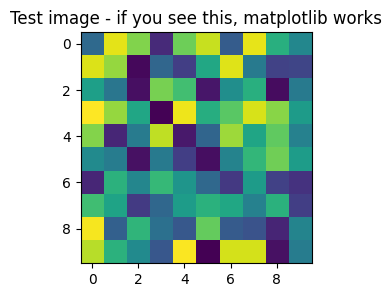

In [4]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import numpy as np
import matplotlib.pyplot as plt
import flashbax as fbx
from functools import partial
from flax.core import FrozenDict
from distrax import Categorical

# Project imports
import her
import base_algorithm2 as base
from jaxmaze.human_dyna import experiments as jaxmaze_experiments
from jaxmaze.human_dyna import multitask_env
from jaxmaze.human_dyna import mazes
from jaxmaze import renderer
from jaxmaze import utils as jaxmaze_utils

# Re-set matplotlib backend after imports (some imports reset it to 'agg')
%matplotlib inline
import matplotlib
print(f"Matplotlib backend: {matplotlib.get_backend()}")

# Test plot
fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(np.random.rand(10, 10), cmap='viridis')
ax.set_title("Test image - if you see this, matplotlib works")
plt.show()

In [5]:
# Minimal config dictionary with required HER parameters
config = {
    # Run params
    "SEED": 42,
    "NUM_ENVS": 8,
    "TRAINING_INTERVAL": 50,
    "TOTAL_TIMESTEPS": 100_000,
    
    # Buffer params
    "BUFFER_SIZE": 10_000,
    "BUFFER_BATCH_SIZE": 4,
    "SAMPLE_LENGTH": 40,  # Sample sequence length
    "TOTAL_BATCH_SIZE": 160,
    "PRIORITY_EXPONENT": 0.9,
    "SAMPLING_PERIOD": 1,
    
    # HER params
    "NUM_HER_GOALS": 5,
    "POSITION_BETA": 1.0,
    "HER_COEFF": 0.1,
    "GAMMA": 0.99,
    
    # Neural net params
    "EMBED_HIDDEN_DIM": 64,
    "MLP_HIDDEN_DIM": 256,
    "NUM_MLP_LAYERS": 0,
    "NUM_EMBED_LAYERS": 0,
    "AGENT_RNN_DIM": 256,
    "ACTIVATION": "leaky_relu",
    "NUM_Q_LAYERS": 2,
    "Q_HIDDEN_DIM": 512,
    
    # Epsilon greedy
    "FIXED_EPSILON": 2,
    "EPSILON_START": 1.0,
    "EPSILON_FINISH": 0.1,
    "ADD_GREEDY_EPSILON": True,
    "EPSILON_MIN": 0.05,
    "EPSILON_MAX": 0.9,
    "EPSILON_BASE": 0.1,
    "NUM_EPSILONS": 256,
    "EVAL_EPSILON": 1.0,  # Fully random actions for data collection
    
    # Optimizer
    "LR": 0.001,
    "LR_LINEAR_DECAY": False,
    "MAX_GRAD_NORM": 80,
    "EPS_ADAM": 0.00001,
    
    # Environment
    "ENV": "jaxmaze",
    
    # Logging
    "MAX_EPISODE_LOG_LEN": 40,
    "LEARNER_EXTRA_LOG_PERIOD": 100,
}

# Compute NUM_UPDATES
config["NUM_UPDATES"] = int(
    config["TOTAL_TIMESTEPS"] // config["NUM_ENVS"] // config["TRAINING_INTERVAL"]
)
print(f"Config NUM_UPDATES: {config['NUM_UPDATES']}")

Config NUM_UPDATES: 250


## Section 2: Environment Setup

In [6]:
# Load image dictionary for rendering
image_dict = jaxmaze_utils.load_image_dict()
# Reshape images to separate blocks and take mean
images = image_dict["images"]
reshaped = images.reshape(len(images), 8, 4, 8, 4, 3)
image_dict["images"] = reshaped.mean(axis=(2, 4)).astype(np.uint8)

print(f"Image dict keys: {image_dict['keys'][:10]}")
print(f"Number of images: {len(image_dict['images'])}")

# Load her_test experiment configuration
num_groups = 2
char2key, group_set, task_objects = mazes.get_group_set(num_groups)

print(f"Group set: {group_set}")
print(f"Task objects: {task_objects}")
print(f"char2key: {char2key}")

No file specified for image dict.
Using: /Users/wilka/git/research/preplay_ai_experiment/libraries/jaxmaze/jaxmaze/image_data.pkl
Image dict keys: ['empty', 'wall', 'apple_sliced', 'spoon', 'onion_sliced_cooked', 'onion_cooked', 'lettuce_sliced_cooked', 'bowl', 'lettuce_dirty', 'orange_dirty']
Number of images: 51


In [31]:
# Create TaskRunner with terminate_with_any=False (HER-specific setting)
task_runner = multitask_env.TaskRunner(
    task_objects=task_objects,
    terminate_with_any=False,  # Important for HER
)

# Create environment
env = multitask_env.HouseMaze(
    task_runner=task_runner,
    num_categories=len(image_dict["keys"]),
)
env = jaxmaze_utils.AutoResetWrapper(env)

# Create environment parameters using her_test maze
env_params = mazes.get_maze_reset_params(
    groups=group_set,
    char2key=char2key,
    maze_str=mazes.her_test,
    make_env_params=True,
    curriculum=False,
)

print(f"her_test maze:\n{mazes.her_test}")
print(f"Number of actions: {env.num_actions()}")

her_test maze:

##################
...B..<.##..C.....
.A###....#D###....
...##.......##....
##################

Number of actions: 4


Initial timestep reward shape: (8,)
Initial observation image shape: (8, 5, 18)
Initial observation task_w shape: (8, 4)
Initial observation state_features shape: (8, 4)


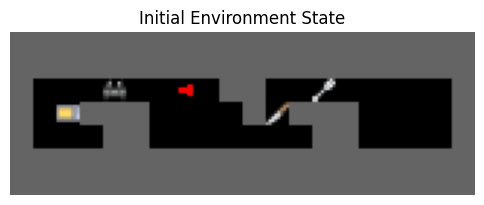

In [10]:
# Create vmapped reset/step functions
def vmap_reset(rng, env_params):
    return jax.vmap(env.reset, in_axes=(0, None))(
        jax.random.split(rng, config["NUM_ENVS"]), env_params
    )

def vmap_step(rng, env_state, action, env_params):
    return jax.vmap(env.step, in_axes=(0, 0, 0, None))(
        jax.random.split(rng, config["NUM_ENVS"]), env_state, action, env_params
    )

# Initialize environment
rng = jax.random.PRNGKey(config["SEED"])
rng, _rng = jax.random.split(rng)
init_timestep = vmap_reset(_rng, env_params)

print(f"Initial timestep reward shape: {init_timestep.reward.shape}")
print(f"Initial observation image shape: {init_timestep.observation.image.shape}")
print(f"Initial observation task_w shape: {init_timestep.observation.task_w.shape}")
print(f"Initial observation state_features shape: {init_timestep.observation.state_features.shape}")

# Rendering function
def jaxmaze_render_fn(state: multitask_env.EnvState):
    return renderer.create_image_from_grid(
        state.grid, state.agent_pos, state.agent_dir, image_dict
    )

# Render initial state
state_0 = jax.tree_util.tree_map(lambda x: x[0], init_timestep.state)
img = jaxmaze_render_fn(state_0)
plt.figure(figsize=(6, 4))
plt.imshow(img)
plt.title("Initial Environment State")
plt.axis("off")
plt.show()

## Section 3: Agent and Actor Initialization

In [11]:
# Create HER agent
rng, _rng = jax.random.split(rng)
agent, network_params, agent_reset_fn = her.make_jaxmaze_agent(
    config=config,
    env=env,
    env_params=env_params,
    example_timestep=init_timestep,
    rng=_rng,
)

print(f"Agent type: {type(agent)}")

Agent type: <class 'her.RnnAgent'>


In [12]:
# Create optimizer
tx = her.make_optimizer(config)

# Create CustomTrainState
train_state = base.CustomTrainState.create(
    apply_fn=agent.apply,
    params=network_params,
    target_network_params=jax.tree_util.tree_map(lambda x: jnp.copy(x), network_params),
    tx=tx,
    timesteps=0,
    n_updates=0,
    n_logs=0,
)

print(f"Train state created with {train_state.n_updates} updates")

Train state created with 0 updates


In [13]:
# Create actor
rng, _rng = jax.random.split(rng)
actor = her.make_actor(config=config, agent=agent, rng=_rng)

print(f"Actor created: train_step={actor.train_step}, eval_step={actor.eval_step}")

Actor created: train_step=<function make_actor.<locals>.actor_step at 0x34dd42f20>, eval_step=<function make_actor.<locals>.eval_step at 0x34dd42840>


In [14]:
# Initialize agent state
rng, _rng = jax.random.split(rng)
init_agent_state = agent_reset_fn(network_params, init_timestep, _rng)

print(f"Agent state type: {type(init_agent_state)}")
print(f"Agent state shapes: {jax.tree_util.tree_map(lambda x: x.shape, init_agent_state)}")

Agent state type: <class 'tuple'>
Agent state shapes: ((8, 256), (8, 256))


## Section 4: Buffer Setup

In [15]:
# Create prioritized trajectory buffer
sample_sequence_length = config.get("SAMPLE_LENGTH") or config["TOTAL_BATCH_SIZE"] // config["BUFFER_BATCH_SIZE"]
period = config.get("SAMPLING_PERIOD", 1)

buffer = fbx.make_prioritised_trajectory_buffer(
    max_length_time_axis=config["BUFFER_SIZE"] // config["NUM_ENVS"],
    min_length_time_axis=sample_sequence_length,
    add_batch_size=config["NUM_ENVS"],
    sample_batch_size=config["BUFFER_BATCH_SIZE"],
    sample_sequence_length=sample_sequence_length,
    period=period,
    priority_exponent=config.get("PRIORITY_EXPONENT", 0.9),
)

buffer = buffer.replace(
    init=jax.jit(buffer.init),
    add=jax.jit(buffer.add, donate_argnums=0),
    sample=jax.jit(buffer.sample),
    can_sample=jax.jit(buffer.can_sample),
)

print(f"Buffer sample_sequence_length: {sample_sequence_length}")

Buffer sample_sequence_length: 40


In [16]:
# Initialize buffer with example transition
dummy_rng = jax.random.PRNGKey(0)
init_preds, action, _ = actor.eval_step(
    train_state, init_agent_state, init_timestep, dummy_rng
)

init_transition = base.Transition(
    init_timestep,
    action=action,
    extras=FrozenDict(preds=init_preds, agent_state=init_agent_state),
)

# Get single example for buffer init
init_transition_example = jax.tree_util.tree_map(lambda x: x[0], init_transition)
buffer_state = buffer.init(init_transition_example)

print(f"Buffer initialized")
print(f"Initial action shape: {action.shape}")

Buffer initialized
Initial action shape: (8,)


## Section 5: Data Collection

In [17]:
# Simple trajectory collection loop (not using scan for debuggability)
from tqdm import tqdm

num_collection_steps = 200  # ~5000 steps total with NUM_ENVS=8

timestep = init_timestep
agent_state = init_agent_state
all_transitions = []

for step in tqdm(range(num_collection_steps)):
    rng, rng_a, rng_s = jax.random.split(rng, 3)
    
    # Get action from actor (using eval_step with EVAL_EPSILON=1.0 for random actions)
    preds, action, new_agent_state = actor.eval_step(
        train_state, agent_state, timestep, rng_a
    )
    
    # Store transition
    transition = base.Transition(
        timestep,
        action=action,
        extras=FrozenDict(preds=preds, agent_state=agent_state),
    )
    all_transitions.append(transition)
    
    # Step environment
    timestep = vmap_step(rng_s, timestep, action, env_params)
    agent_state = new_agent_state
    
print(f"\nTotal transitions collected: {num_collection_steps * config['NUM_ENVS']}")

100%|████████████████████████████████████████████████████████████| 200/200 [01:00<00:00,  3.33it/s]


Total transitions collected: 1600


In [18]:
# Add transitions to buffer
# Stack transitions: list of [B, ...] -> [T, B, ...]
def stack_transitions(transitions):
    return jax.tree_util.tree_map(
        lambda *xs: jnp.stack(xs, axis=0),
        *transitions
    )

stacked_transitions = stack_transitions(all_transitions)
print(f"Stacked transitions timestep reward shape: {stacked_transitions.timestep.reward.shape}")

# Swap to [B, T, ...] for buffer
buffer_transitions = jax.tree_util.tree_map(
    lambda x: jnp.swapaxes(x, 0, 1), stacked_transitions
)
print(f"Buffer transitions timestep reward shape: {buffer_transitions.timestep.reward.shape}")

# Add to buffer
buffer_state = buffer.add(buffer_state, buffer_transitions)
print(f"Buffer can sample: {buffer.can_sample(buffer_state)}")

Stacked transitions timestep reward shape: (200, 8)
Buffer transitions timestep reward shape: (8, 200)
Buffer can sample: True


## Section 6: Sample from Buffer and Test Goal Sampling

Sampled batch experience timestep reward shape: (4, 40)
Sampled batch indices: [1403 2519 6387 8798]
Timesteps reward shape: (40, 4)
Timesteps observation state_features shape: (40, 4, 4)
Found achievement in batch 0 (sum: 1.00)


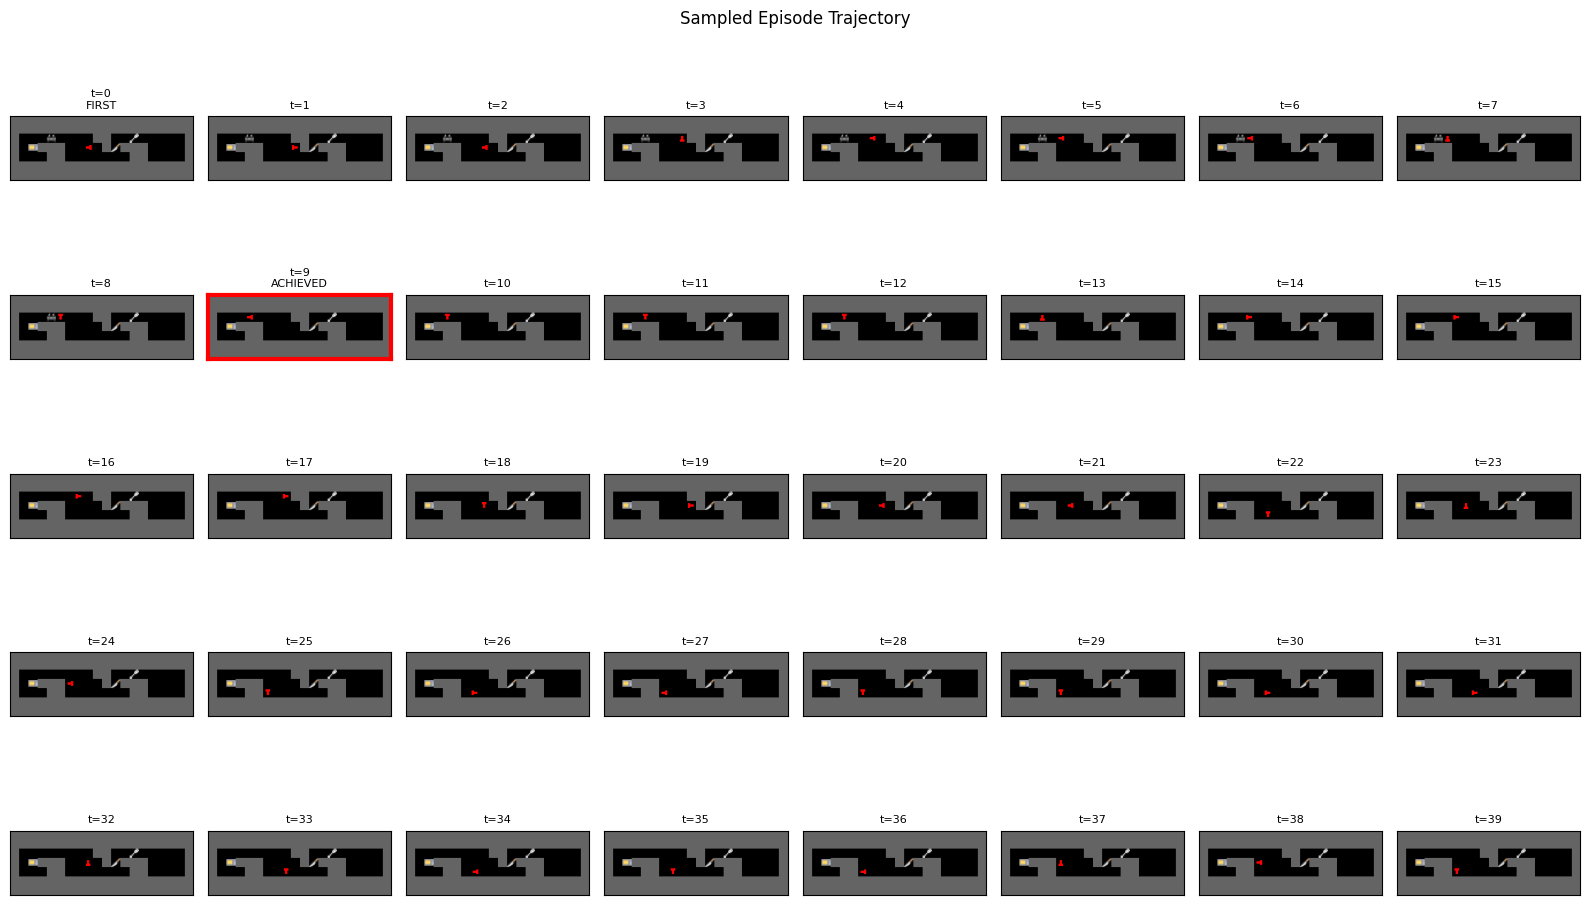

In [97]:
from math import ceil

task_vector_fn, achievement_fn, position_fn = her.ENVIRONMENT_TO_GOAL_FNS["jaxmaze"]

def sample_batch(rng):
    # Sample a batch from buffer
    rng, _rng = jax.random.split(rng)
    sampled_batch = buffer.sample(buffer_state, _rng)
    
    print(f"Sampled batch experience timestep reward shape: {sampled_batch.experience.timestep.reward.shape}")
    print(f"Sampled batch indices: {sampled_batch.indices}")

    # Extract timesteps from sampled data
    # Convert from [B, T, ...] to [T, B, ...] for processing
    data = base.batch_to_sequence(sampled_batch.experience)
    timesteps = data.timestep

    print(f"Timesteps reward shape: {timesteps.reward.shape}")
    print(f"Timesteps observation state_features shape: {timesteps.observation.state_features.shape}")
    return timesteps

def sample_until_achievement(rng):
    """Sample batches until finding one with achievements, return single trajectory."""
    for attempt in range(10):
        rng, _rng = jax.random.split(rng)
        timesteps = sample_batch(_rng)
        
        # Check achievements across all batches: [T, B, D]
        achievements = achievement_fn(timesteps)
        # Sum over time and achievement dims to get total per batch: [B]
        achievement_per_batch = achievements.sum(axis=(0, -1))
        
        # Find first batch with any achievement
        has_achievement = achievement_per_batch > 0
        if has_achievement.any():
            batch_idx = int(jnp.argmax(has_achievement))
            print(f"Found achievement in batch {batch_idx} (sum: {achievement_per_batch[batch_idx]:.2f})")
            # Return just that batch element
            timesteps_0 = jax.tree_util.tree_map(lambda x: x[:, batch_idx], timesteps)
            return timesteps_0
        
        print(f"Attempt {attempt + 1}: No achievements found, resampling...")

    print("No object ever achieved after 10 attempts! Using batch 0.")
    return jax.tree_util.tree_map(lambda x: x[:, 0], timesteps)

def visualize_timesteps(timesteps_0):
    """Visualize a single trajectory with achievements marked."""
    nT = len(timesteps_0.reward)
    n_episode_steps = min(nT, config.get("MAX_EPISODE_LOG_LEN", 40))
    
    ncols_img = 8
    n_image_rows = ceil(n_episode_steps / ncols_img)
    
    # Get achievements to mark
    achievements = achievement_fn(timesteps_0)  # [T, D]
    achieved_at_t = achievements.sum(-1) > 0  # [T]
    
    fig, axes = plt.subplots(n_image_rows, ncols_img, figsize=(2*ncols_img, 2*n_image_rows))
    if n_image_rows == 1:
        axes = axes[None, :]
    
    for idx in range(n_episode_steps):
        row, col = divmod(idx, ncols_img)
        ax = axes[row, col]
        
        state_at_t = jax.tree_util.tree_map(lambda x: x[idx], timesteps_0.state)
        img = jaxmaze_render_fn(state_at_t)
        ax.imshow(img)
        
        title = f"t={idx}"
        if idx == 0:
            title += "\nFIRST"
        if achieved_at_t[idx]:
            title += "\nACHIEVED"
            # Red box around achieved timesteps
            for spine in ax.spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(3)
        ax.set_title(title, fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Hide unused subplots
    for idx in range(n_episode_steps, n_image_rows * ncols_img):
        row, col = divmod(idx, ncols_img)
        axes[row, col].axis("off")
    
    plt.suptitle("Sampled Episode Trajectory", fontsize=12)
    plt.tight_layout()
    plt.show()


rng, _rng = jax.random.split(rng)
timesteps_0 = sample_until_achievement(_rng)
visualize_timesteps(timesteps_0)

In [98]:
# Create sample_goals function from her.make_loss_fn_class
# This is the key function we want to test

task_vector_fn, achievement_fn, position_fn = her.ENVIRONMENT_TO_GOAL_FNS["jaxmaze"]

def sample_goals(timesteps, rng):
    """Sample goals from timesteps based on achievements."""
    achievements = achievement_fn(timesteps)
    # T, if vector non-zero, achieved
    goal_achieved = achievements.sum(-1)
    
    # all positions were achieved
    position_achieved = jnp.ones_like(goal_achieved)
    
    # T
    logits = goal_achieved + config["POSITION_BETA"] * position_achieved
    probabilities = jax.nn.softmax(logits)

    # N
    indices = Categorical(probs=probabilities).sample(
        seed=rng, sample_shape=(config["NUM_HER_GOALS"],)
    )
    
    index = lambda x, i: jax.lax.dynamic_index_in_dim(x, i, keepdims=False)
    index = jax.vmap(index, (None, 0), 0)
    
    # [N, C] <- [T, C], [N]
    features_at_indices = index(achievements, indices)
    
    # [N, 2] <- [T, 2], [N]
    positions_at_indices = index(position_fn(timesteps), indices)

    # Visualize
    visualize_goals(timesteps, goal_achieved, position_achieved, probabilities, indices)
    
    return her.GoalPosition(
        jax.lax.stop_gradient(features_at_indices),
        jax.lax.stop_gradient(positions_at_indices) + 1,
    ), indices, probabilities

## Sample goals

In [99]:
# Create sample_goals function from her.make_loss_fn_class
# This is the key function we want to test

task_vector_fn, achievement_fn, position_fn = her.ENVIRONMENT_TO_GOAL_FNS["jaxmaze"]

def plot_probs(goal_achieved, position_achieved, probabilities, goal_indices, beta):
    """Plot goal_achieved, position_achieved, and probabilities with sampled indices marked."""
    fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)
    
    T = len(probabilities)
    x = np.arange(T)
    
    # Row 1: Goal achieved
    ax = axes[0]
    ax.bar(x, np.array(goal_achieved), alpha=0.7, color='blue')
    for idx in goal_indices:
        ax.axvline(int(idx), color='red', linestyle='--', alpha=0.7, linewidth=1.5)
    ax.set_ylabel("Goal Achieved")
    ax.set_title("Goal Achieved (sum of achievements at each timestep)")
    ax.grid(True, alpha=0.3)
    
    # Row 2: Position achieved
    ax = axes[1]
    ax.bar(x, np.array(position_achieved), alpha=0.7, color='green')
    for idx in goal_indices:
        ax.axvline(int(idx), color='red', linestyle='--', alpha=0.7, linewidth=1.5)
    ax.set_ylabel("Position Achieved")
    ax.set_title("Position Achieved (always 1 for all positions)")
    ax.grid(True, alpha=0.3)
    
    # Row 3: Sampling probabilities
    ax = axes[2]
    ax.bar(x, np.array(probabilities), alpha=0.7, color='purple')
    for i, idx in enumerate(goal_indices):
        ax.axvline(int(idx), color='red', linestyle='--', alpha=0.7, linewidth=1.5,
                   label='Sampled' if i == 0 else None)
        ax.scatter(int(idx), float(probabilities[int(idx)]), color='red', s=100, zorder=5)
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Probability")
    ax.set_title(f"Sampling Probabilities ({beta} * goal + position)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.suptitle("HER Goal Sampling Components", fontsize=14)
    plt.tight_layout()
    plt.show()

def sample_goals(timesteps, rng, beta=10):
    """Sample goals from timesteps based on achievements."""
    achievements = achievement_fn(timesteps)
    # T, if vector non-zero, achieved
    goal_achieved = achievements.sum(-1)
    
    # all positions were achieved
    position_achieved = jnp.ones_like(goal_achieved)
    
    # T
    logits = beta*goal_achieved + position_achieved
    # probabilities = jax.nn.softmax(logits)
    probabilities = logits/(logits.sum(-1)+1e-5)

    # N
    indices = Categorical(probs=probabilities).sample(
        seed=rng, sample_shape=(config["NUM_HER_GOALS"],)
    )
    
    index = lambda x, i: jax.lax.dynamic_index_in_dim(x, i, keepdims=False)
    index = jax.vmap(index, (None, 0), 0)
    
    # [N, C] <- [T, C], [N]
    features_at_indices = index(achievements, indices)
    
    # [N, 2] <- [T, 2], [N]
    positions_at_indices = index(position_fn(timesteps), indices)

    plot_probs(goal_achieved, position_achieved, probabilities, indices, beta)
    
    return her.GoalPosition(
        jax.lax.stop_gradient(features_at_indices),
        jax.lax.stop_gradient(positions_at_indices) + 1,
    ), indices, probabilities

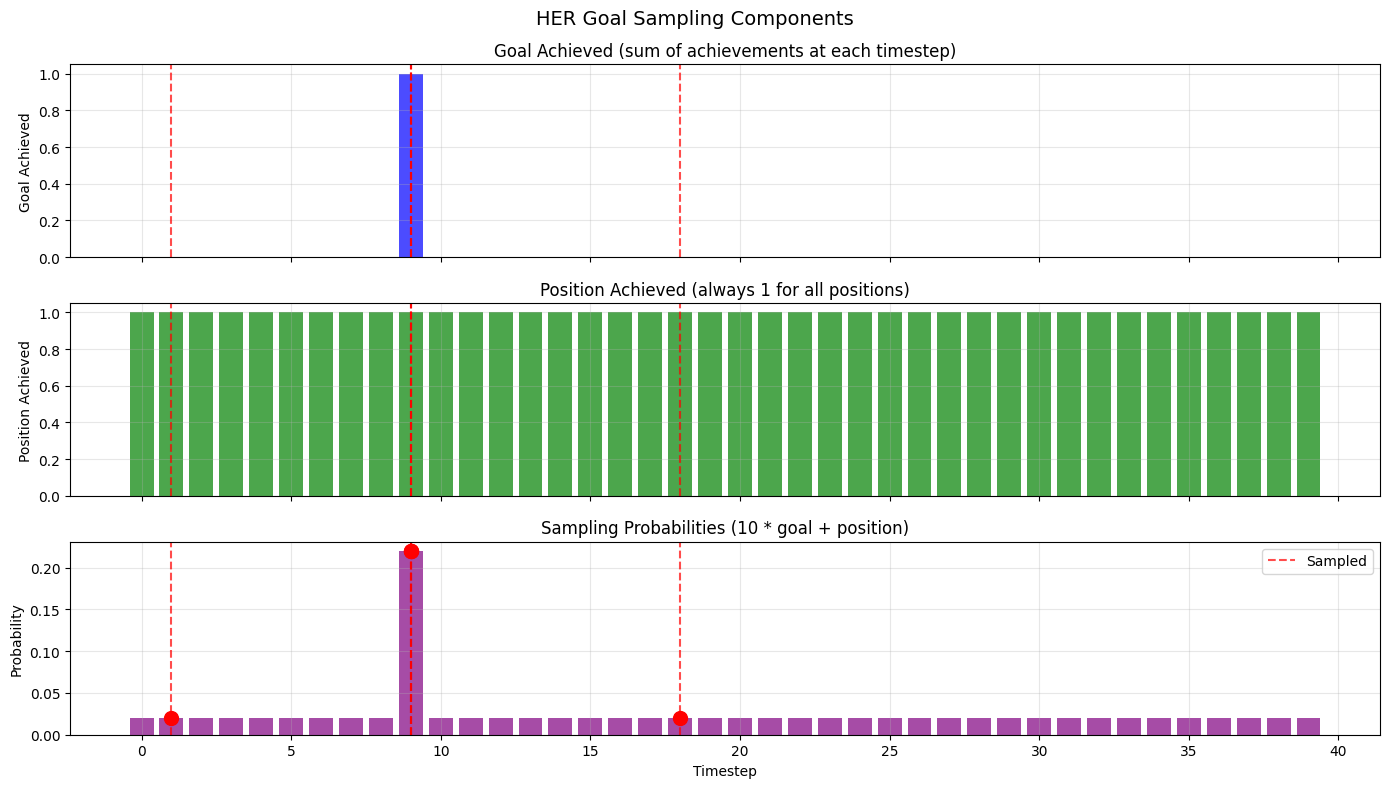

In [111]:
rng, goal_rng_ = jax.random.split(rng)
goal, goal_indices, sampling_probs = sample_goals(timesteps_0, goal_rng_, beta=10)

## Section 7: Visualization

In [113]:
# Define her_reward_fn for computing HER rewards

def her_reward_fn(timesteps, new_goal):
    """Compute reward info for a single goal applied to trajectory."""
    task_vector_fn, achievement_fn, position_fn = her.ENVIRONMENT_TO_GOAL_FNS["jaxmaze"]

    # achievement reward
    goal_task_vector = new_goal.goal  # [D]
    goal_achievements = achievement_fn(timesteps)  # [T, D]
    goal_reward = (goal_task_vector[None] * goal_achievements).sum(-1)  # [T]

    # position reward
    position = new_goal.position - 1  # [2]
    position_achievement = position_fn(timesteps)  # [T, 2]
    position_reward = jax.vmap(jnp.equal, (None, 0))(position, position_achievement)
    position_reward = position_reward.all(-1).astype(jnp.float32)

    assert goal_reward.ndim == 1
    assert position_reward.ndim == 1
    reward = (
      0.5 * position_reward +
      0.5 * goal_reward
    )
    reward = jax.tree_util.tree_map(jax.lax.stop_gradient, reward)

    T = goal_achievements.shape[0]
    goal_task_vector = jnp.tile(goal_task_vector[None], [T, 1])  # [T, D]
    position = jnp.tile(position[None], [T, 1])  # [T, 2]

    return {
      'reward': reward,
      'goal_reward': goal_reward,
      'goal_task_vector': goal_task_vector,
      'goal_achievements': goal_achievements,
      'position_reward': position_reward,
      'position_task_vector': position,
      'position_achievement': position_achievement,
    }


Visualizing HER reward info for 5 sampled goals...
Goal indices: [9, 18, 1, 9, 9]



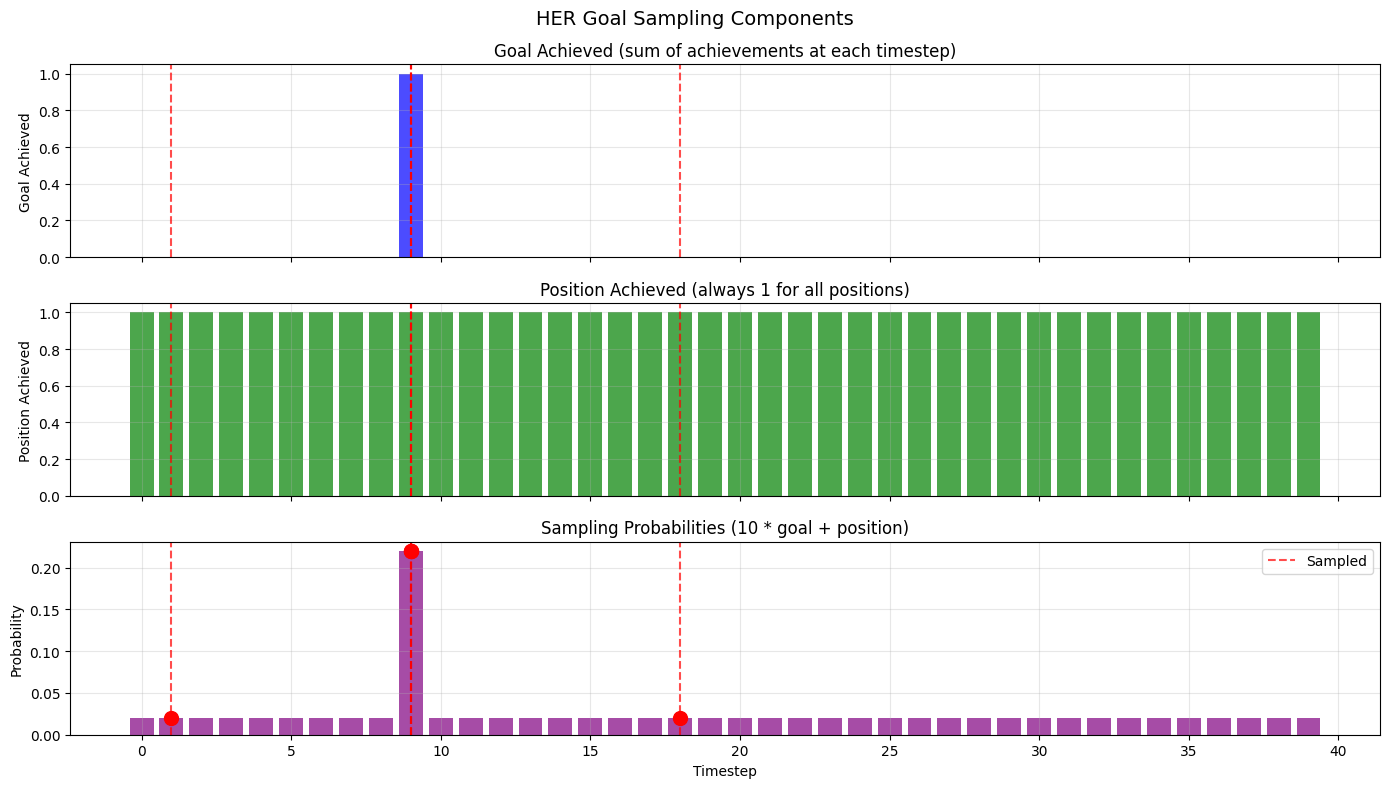

--- Goal 0 (t=9) ---
  goal.goal: [0. 1. 0. 0.]
  goal.position: [2 4]


/var/folders/xy/l2ynyz5d10x4c52rnkln7tp80000gr/T/ipykernel_85447/502841825.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


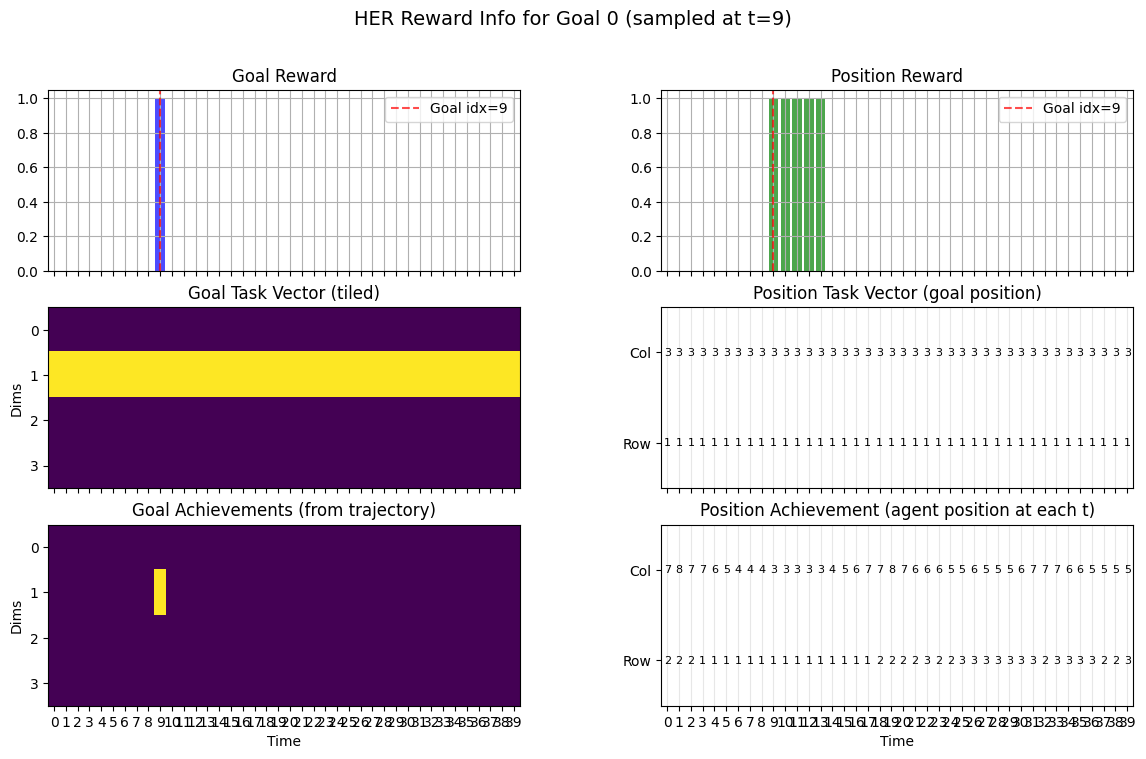

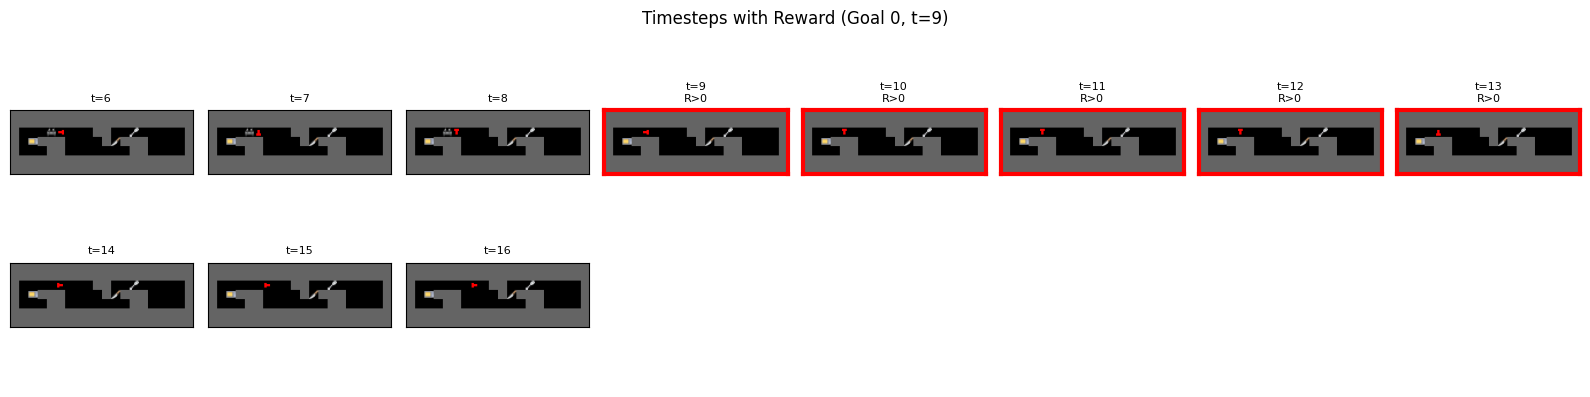

--- Goal 1 (t=18) ---
  goal.goal: [0. 0. 0. 0.]
  goal.position: [3 8]


/var/folders/xy/l2ynyz5d10x4c52rnkln7tp80000gr/T/ipykernel_85447/502841825.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


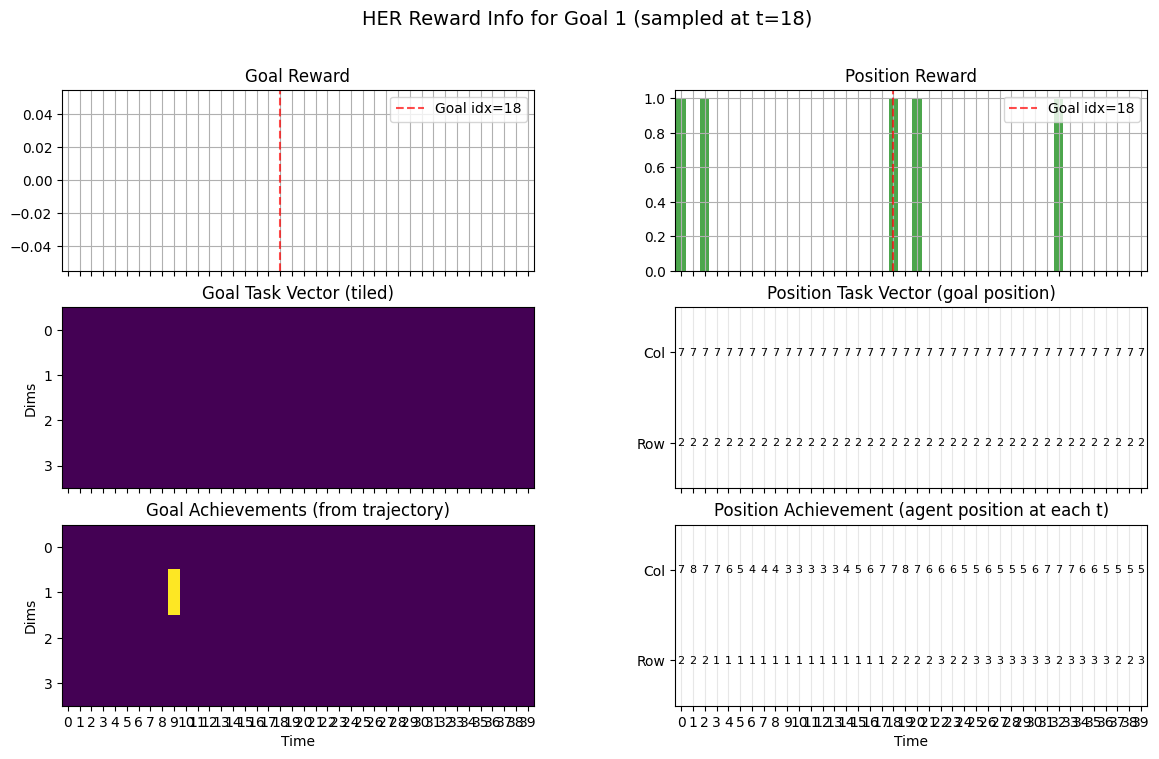

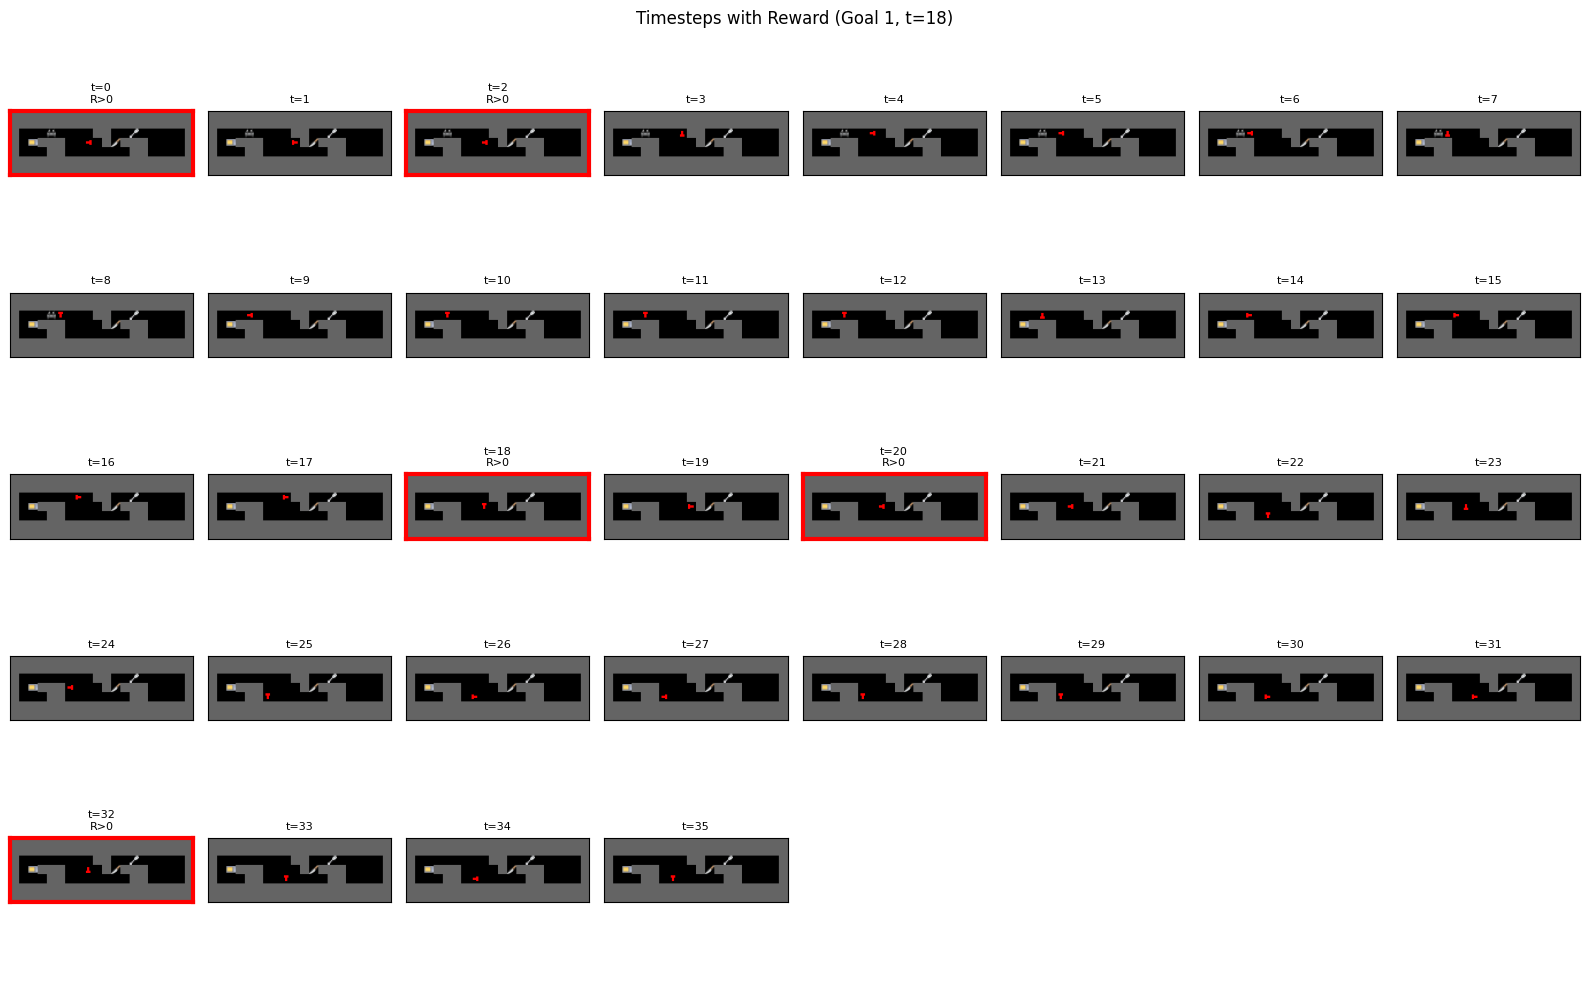

--- Goal 2 (t=1) ---
  goal.goal: [0. 0. 0. 0.]
  goal.position: [3 9]


/var/folders/xy/l2ynyz5d10x4c52rnkln7tp80000gr/T/ipykernel_85447/502841825.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


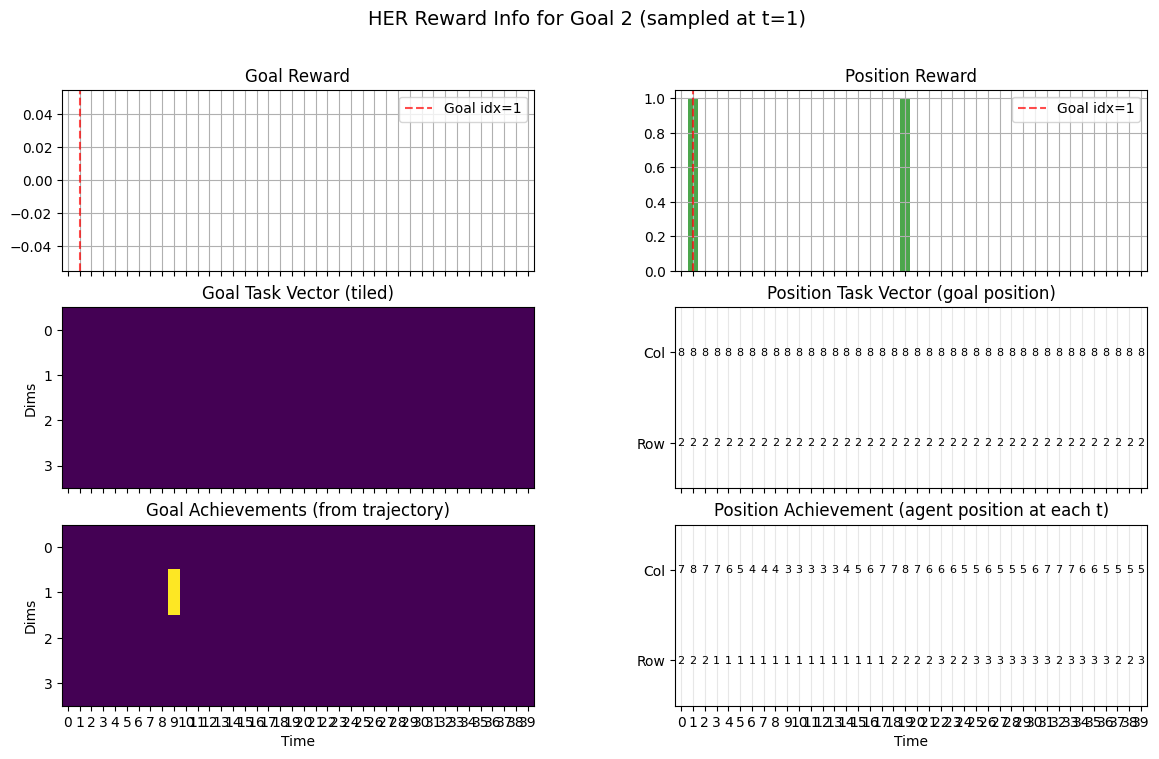

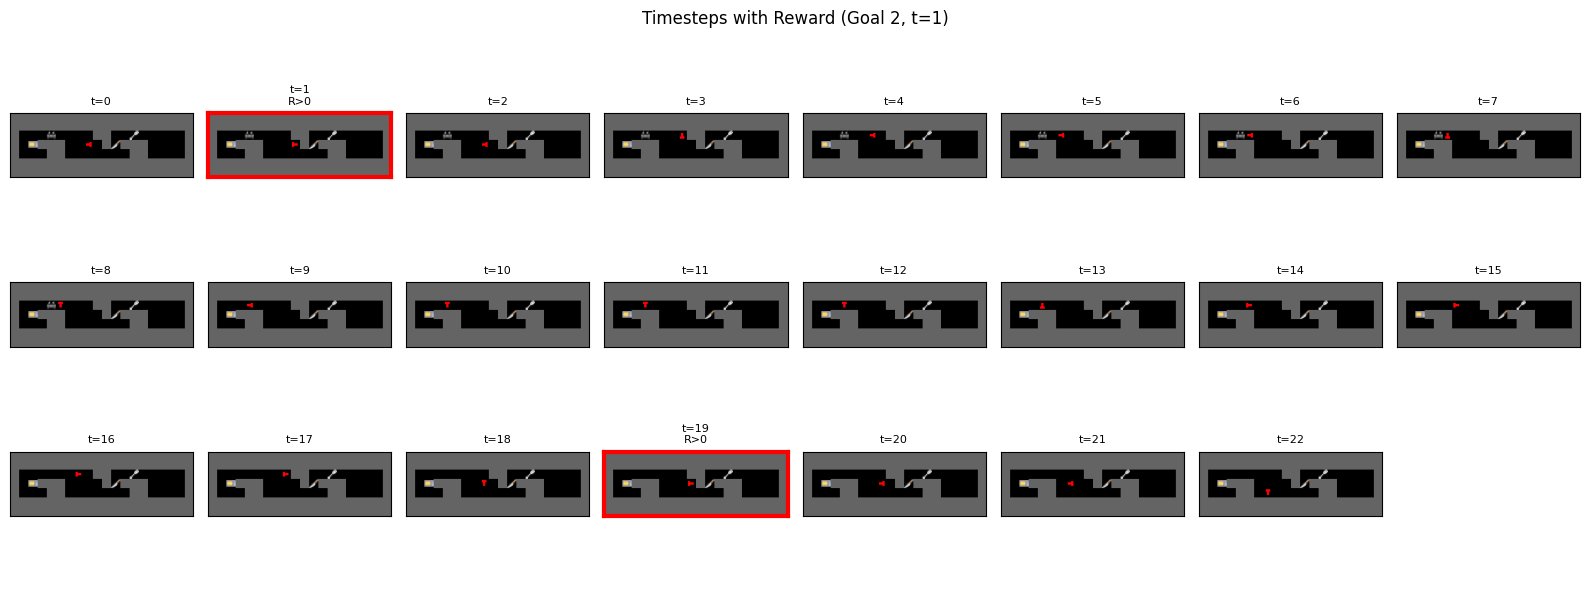

--- Goal 3 (t=9) ---
  goal.goal: [0. 1. 0. 0.]
  goal.position: [2 4]


/var/folders/xy/l2ynyz5d10x4c52rnkln7tp80000gr/T/ipykernel_85447/502841825.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


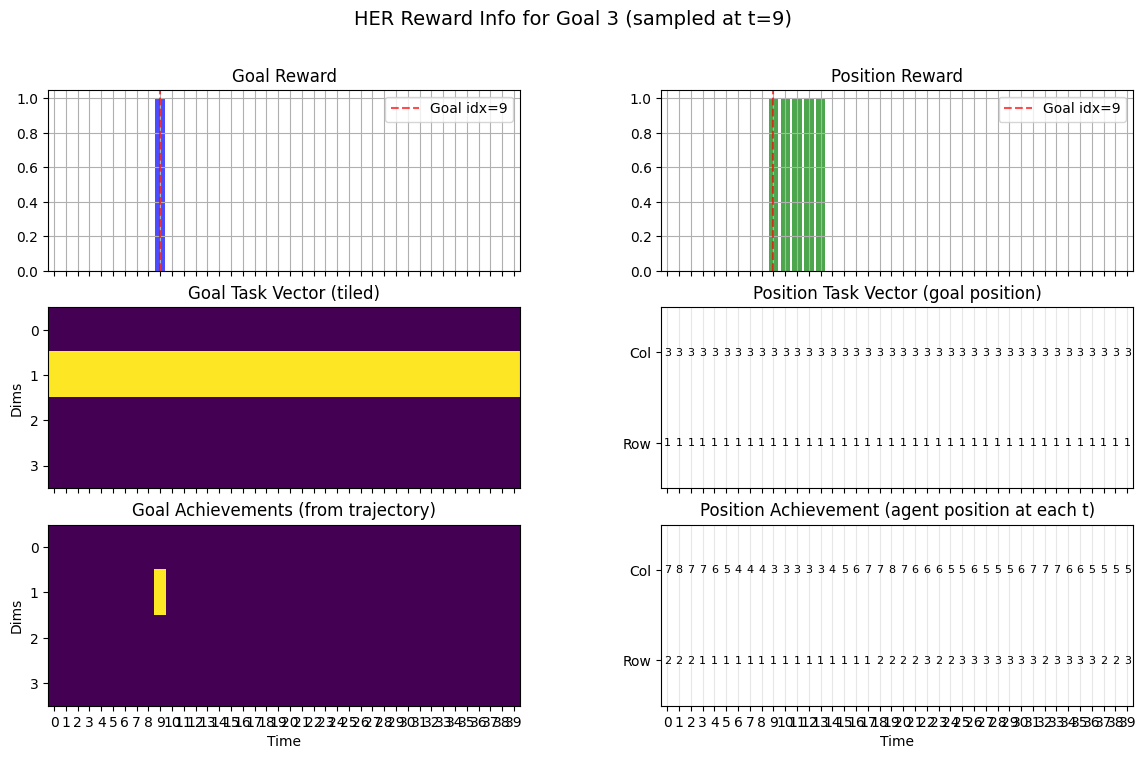

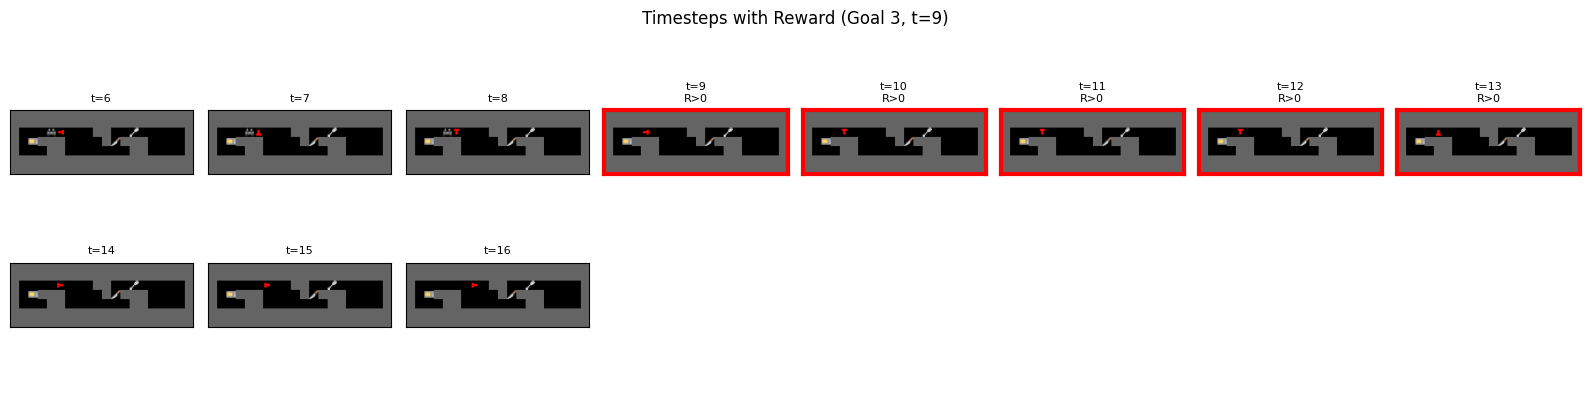

--- Goal 4 (t=9) ---
  goal.goal: [0. 1. 0. 0.]
  goal.position: [2 4]


/var/folders/xy/l2ynyz5d10x4c52rnkln7tp80000gr/T/ipykernel_85447/502841825.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


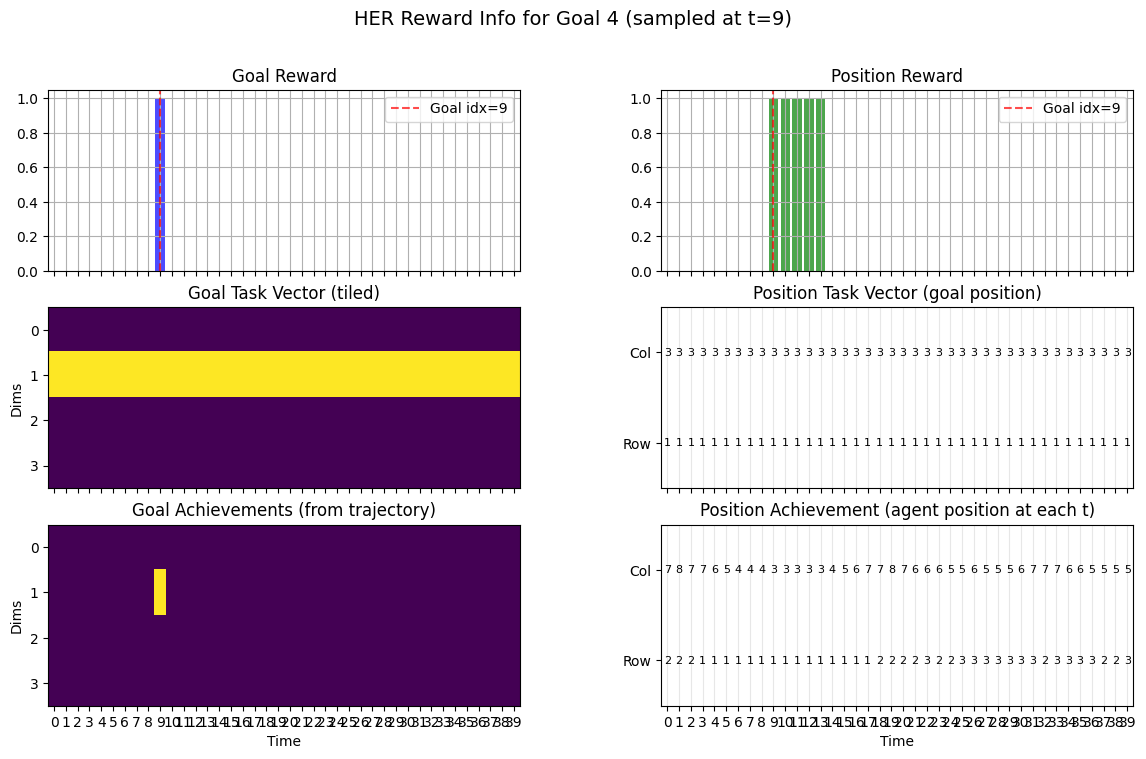

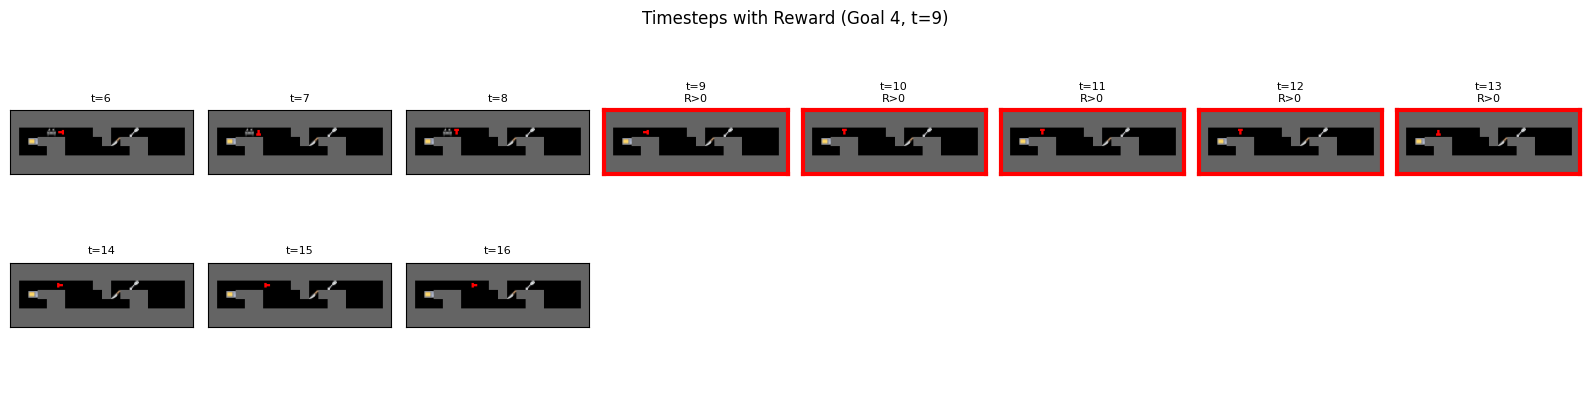

In [116]:
# Visualize HER reward info for ALL sampled goals

def plot_her_reward_info(timesteps_0, single_goal, goal_idx_int, goal_num):
    """Plot reward info for a single HER goal."""
    reward_info = her_reward_fn(timesteps_0, single_goal)
    nT = len(timesteps_0.reward)
    
    fig, axes = plt.subplots(3, 2, figsize=(14, 8), sharex='col', gridspec_kw={'wspace': 0.3})
    
    # Column 0: Goal reward info
    ax = axes[0, 0]
    ax.bar(range(nT), np.array(reward_info['goal_reward']), alpha=0.7, color='blue')
    ax.axvline(goal_idx_int, color='red', linestyle='--', alpha=0.7, label=f"Goal idx={goal_idx_int}")
    ax.set_title("Goal Reward")
    ax.legend()
    ax.grid(True)
    ax.set_xticks(range(nT))
    
    ax = axes[1, 0]
    goal_tv = reward_info['goal_task_vector'].T  # [D, T]
    ax.imshow(np.array(goal_tv), aspect="auto", cmap="viridis", interpolation="nearest")
    ax.set_title("Goal Task Vector (tiled)")
    ax.set_ylabel("Dims")
    ax.set_yticks(range(goal_tv.shape[0]))
    ax.set_xticks(range(nT))
    
    ax = axes[2, 0]
    goal_ach = reward_info['goal_achievements'].T  # [D, T]
    ax.imshow(np.array(goal_ach), aspect="auto", cmap="viridis", interpolation="nearest")
    ax.set_title("Goal Achievements (from trajectory)")
    ax.set_ylabel("Dims")
    ax.set_yticks(range(goal_ach.shape[0]))
    ax.set_xticks(range(nT))
    ax.set_xlabel("Time")
    
    # Column 1: Position reward info
    ax = axes[0, 1]
    ax.bar(range(nT), np.array(reward_info['position_reward']), alpha=0.7, color='green')
    ax.axvline(goal_idx_int, color='red', linestyle='--', alpha=0.7, label=f"Goal idx={goal_idx_int}")
    ax.set_title("Position Reward")
    ax.legend()
    ax.grid(True)
    ax.set_xticks(range(nT))
    
    # Position Task Vector - show integer values as text
    ax = axes[1, 1]
    pos_tv = np.array(reward_info['position_task_vector'])  # [T, 2]
    ax.set_ylim(-0.5, 1.5)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Row', 'Col'])
    ax.set_xlim(-0.5, nT - 0.5)
    for t in range(min(len(pos_tv), nT)):
        for d in range(pos_tv.shape[1]):
            ax.text(t, d, str(int(pos_tv[t, d])), ha='center', va='center', fontsize=8)
    ax.set_title(f"Position Task Vector (goal position)")
    ax.set_xticks(range(nT))
    ax.grid(True, axis='x', alpha=0.3)
    
    # Position Achievement - show integer values as text
    ax = axes[2, 1]
    pos_ach = np.array(reward_info['position_achievement'])  # [T, 2]
    ax.set_ylim(-0.5, 1.5)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Row', 'Col'])
    ax.set_xlim(-0.5, nT - 0.5)
    for t in range(min(len(pos_ach), nT)):
        for d in range(pos_ach.shape[1]):
            ax.text(t, d, str(int(pos_ach[t, d])), ha='center', va='center', fontsize=8)
    ax.set_title("Position Achievement (agent position at each t)")
    ax.set_xticks(range(nT))
    ax.grid(True, axis='x', alpha=0.3)
    ax.set_xlabel("Time")
    
    plt.suptitle(f"HER Reward Info for Goal {goal_num} (sampled at t={goal_idx_int})", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # === NEW: Visualize timesteps around reward ===
    reward = np.array(reward_info['reward'])
    reward_positive = reward > 0

    if reward_positive.any():
        earliest = int(np.argmax(reward_positive))
        latest = int(len(reward) - 1 - np.argmax(reward_positive[::-1]))
        start_idx = max(0, earliest - 3)
        end_idx = min(nT, latest + 4)
    else:
        start_idx = max(0, goal_idx_int - 3)
        end_idx = min(nT, goal_idx_int + 4)

    timesteps_range = range(start_idx, end_idx)
    n_steps = len(timesteps_range)
    ncols = 8
    nrows = ceil(n_steps / ncols)

    fig2, axes2 = plt.subplots(nrows, ncols, figsize=(2*ncols, 2*nrows))
    if nrows == 1:
        axes2 = axes2[None, :]

    for plot_idx, t in enumerate(timesteps_range):
        row, col = divmod(plot_idx, ncols)
        ax = axes2[row, col]

        state_at_t = jax.tree_util.tree_map(lambda x: x[t], timesteps_0.state)
        img = jaxmaze_render_fn(state_at_t)
        ax.imshow(img)

        title = f"t={t}"
        if reward[t] > 0:
            title += "\nR>0"
            for spine in ax.spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(3)

        ax.set_title(title, fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])

    # Hide unused subplots
    for plot_idx in range(n_steps, nrows * ncols):
        row, col = divmod(plot_idx, ncols)
        axes2[row, col].axis("off")

    plt.suptitle(f"Timesteps with Reward (Goal {goal_num}, t={goal_idx_int})", fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return reward_info

# Plot for ALL sampled goals
n_goals = len(goal_indices)
print(f"Visualizing HER reward info for {n_goals} sampled goals...")
print(f"Goal indices: {[int(g) for g in goal_indices]}\n")


goal, goal_indices, sampling_probs = sample_goals(timesteps_0, goal_rng_, beta=10)
for i in range(n_goals):
    single_goal = jax.tree_util.tree_map(lambda x: x[i], goal)
    goal_idx_int = int(goal_indices[i])
    print(f"--- Goal {i} (t={goal_idx_int}) ---")
    print(f"  goal.goal: {np.array(single_goal.goal)}")
    print(f"  goal.position: {np.array(single_goal.position)}")
    plot_her_reward_info(timesteps_0, single_goal, goal_idx_int, i)